In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score
from collections import Counter

import statsmodels.api as sm

In [86]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')
purelst = pd.read_csv('listings.csv.gz')

In [87]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [88]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [89]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [90]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [91]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [92]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [93]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [94]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [95]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [96]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [97]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [98]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [99]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [100]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [101]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [102]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [103]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [104]:
listd=create_dummies(listd,'zipcode')

In [105]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [106]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [107]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [108]:
listd.shape

(4669, 50)

In [109]:
y=listd.price
X=listd.copy()
X=X.drop(['price'],axis=1)

In [110]:
# X=dflreg.drop([listd_insig_cols],axis=1)
# listd.drop(listd_drop_cols,axis=1,inplace=True )

In [111]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [112]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [113]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3735, 49) (747, 49) (934, 49)
(3735,) (747,) (934,)


In [114]:
X_train.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,cleaning_fee,guests_included,room_type_full,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
4600,False,True,2,1.0,0,1.0,True,15.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3946,False,True,3,1.0,2,2.0,True,65.0,1,1,...,1,0,0,0,0,0,0,0,0,0
3202,True,True,4,1.0,1,2.0,True,70.0,1,1,...,0,0,0,0,0,0,0,0,0,0
1757,False,True,2,2.0,1,1.0,True,75.0,2,1,...,0,0,0,0,0,0,0,0,0,0
3481,True,True,6,3.0,4,4.0,True,500.0,7,1,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# X_train._get_numeric_data().info()

In [116]:
# -------------------------------------------------------

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

[0.         0.         0.0388659  0.0259377  0.7159839  0.
 0.         0.17143705 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04777545 0.
 0.        ]


<BarContainer object of 49 artists>

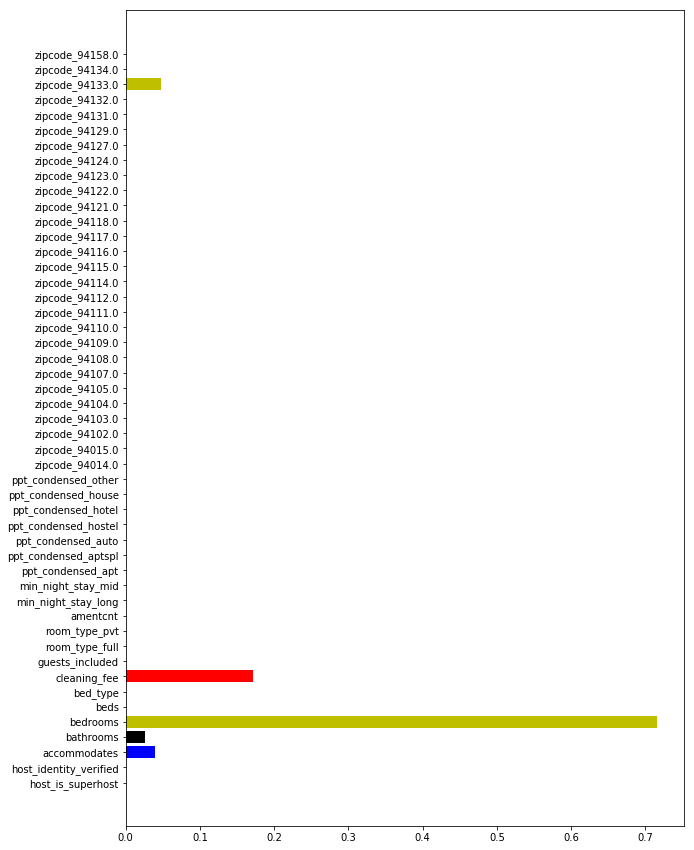

In [161]:
featurelist=X_train.columns
featureimp= regr.feature_importances_
print(featureimp)

fig=plt.figure(figsize=(10,15))
ax1=fig.add_subplot(111)
ax1.barh(featurelist,featureimp,color='rgbkymc')

In [130]:
print(regr.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

[159.97959216]


In [131]:
y_pred=regr.predict(X_test)

In [132]:
y_pred

array([463.34575048, 159.97959216, 159.97959216, 159.97959216,
       159.97959216, 180.6660266 , 159.97959216, 441.13267411,
       159.97959216, 180.6660266 , 498.07822252, 159.97959216,
       159.97959216, 159.97959216, 159.97959216, 180.6660266 ,
       218.82542831, 495.22203139, 159.97959216, 159.97959216,
       159.97959216, 180.6660266 , 498.07822252, 441.13267411,
       218.82542831, 180.6660266 , 159.97959216, 159.97959216,
       159.97959216, 180.6660266 , 159.97959216, 159.97959216,
       159.97959216, 159.97959216, 180.6660266 , 159.97959216,
       159.97959216, 159.97959216, 180.6660266 , 159.97959216,
       159.97959216, 180.6660266 , 159.97959216, 159.97959216,
       159.97959216, 180.6660266 , 552.1675798 , 159.97959216,
       218.82542831, 159.97959216, 159.97959216, 218.82542831,
       159.97959216, 159.97959216, 441.13267411, 495.22203139,
       218.82542831, 159.97959216, 159.97959216, 159.97959216,
       218.82542831, 159.97959216, 159.97959216, 159.97

In [141]:
rf_score=regr.score(X_test,y_test)
rf_score

0.4062707887104541

In [134]:
#Building Residual DF

# dfpred= y_test.to_frame()
dfpred = pd.DataFrame()
dfpred['price'] = y_test
dfpred['rf_preds'] = y_pred
dfpred['rf_resid'] = dfpred.rf_preds-dfpred.price
dfpred['rf_residpct'] = (dfpred.rf_preds-dfpred.price)/dfpred.price
dfpred.head()

,price,rf_preds,rf_resid,rf_residpct
2162,587.0,463.345750,-123.654250,-0.210655
4313,275.0,159.979592,-115.020408,-0.418256
3889,115.0,159.979592,44.979592,0.391127
1532,300.0,159.979592,-140.020408,-0.466735
2498,250.0,159.979592,-90.020408,-0.360082


In [135]:
dfpred[dfpred.price > 1000]

,price,rf_preds,rf_resid,rf_residpct
110,1200.0,498.078223,-701.921777,-0.584935
687,1050.0,441.132674,-608.867326,-0.579874
1539,1050.0,552.167580,-497.832420,-0.474126
2449,1895.0,552.167580,-1342.832420,-0.708619
4082,1100.0,498.078223,-601.921777,-0.547202
707,1450.0,552.167580,-897.832420,-0.619195
1179,1100.0,495.222031,-604.777969,-0.549798
4275,1285.0,552.167580,-732.832420,-0.570298
1223,1250.0,552.167580,-697.832420,-0.558266
67,1100.0,495.222031,-604.777969,-0.549798


In [136]:
dfpred[dfpred.price < 100]

,price,rf_preds,rf_resid,rf_residpct
3318,85.0,159.979592,74.979592,0.882113
3832,82.0,159.979592,77.979592,0.950971
3392,75.0,159.979592,84.979592,1.133061
170,45.0,159.979592,114.979592,2.555102
2506,80.0,159.979592,79.979592,0.999745
2817,59.0,159.979592,100.979592,1.711519
3000,85.0,159.979592,74.979592,0.882113
3124,60.0,159.979592,99.979592,1.666327
1961,50.0,159.979592,109.979592,2.199592
2914,90.0,159.979592,69.979592,0.777551


Text(0,0.5,'RESIDUAL PCT')

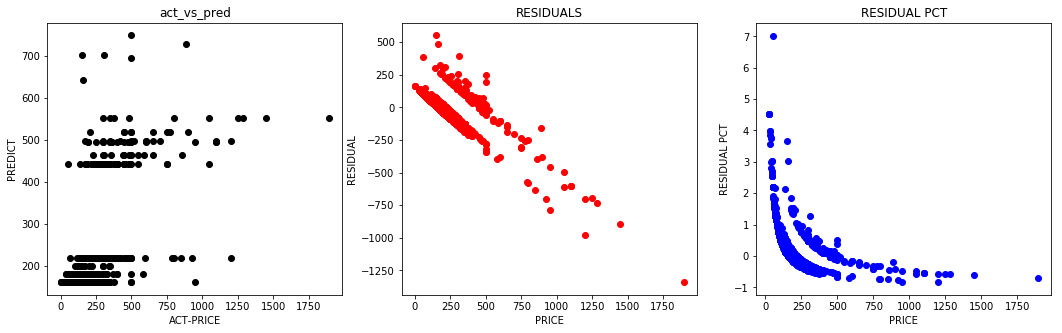

In [137]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_test, y_pred,  color='black')
ax1.set_title('act_vs_pred')
ax1.set_xlabel('ACT-PRICE')
ax1.set_ylabel('PREDICT')

ax2.scatter(dfpred.price,dfpred.rf_resid, color='red')
ax2.set_title('RESIDUALS')
ax2.set_xlabel('PRICE')
ax2.set_ylabel('RESIDUAL')

ax3.scatter(dfpred.price,dfpred.rf_residpct, color='blue')
ax3.set_title('RESIDUAL PCT')
ax3.set_xlabel('PRICE')
ax3.set_ylabel('RESIDUAL PCT')